In [25]:
import requests
import json

def get_rating_data(ratings_id, host="http://localhost:9877"):
    response = requests.get(f"{host}/ratings?show_scores=True")
    ratings = response.json()
    rating = next(r for r in ratings if r['id'] == ratings_id)

    response = requests.get(f"{host}/testsets/{rating['testset_id']}")
    content = response.json()

    questions_json = content["questions"]
    questions = json.loads(questions_json)

    scores_json = rating['scores']
    scores = json.loads(scores_json)

    return rating, questions, scores

In [26]:
def merge_questions_and_scores(questions, scores):
    """
    Merge questions and scores into a single DataFrame.
    
    Args:
        questions (dict): Dictionary containing questions data
        scores (dict): Dictionary containing scores data
        
    Returns:
        pd.DataFrame: Merged DataFrame containing both questions and scores
    """
    import pandas as pd
    
    df_scores = pd.DataFrame(scores)
    reshaped_scores = df_scores.to_dict('records')

    df_questions = pd.DataFrame(questions)
    reshaped_questions = df_questions.reset_index().rename(columns={'index': 'id'}).to_dict('records')

    if not len(reshaped_questions) == len(reshaped_scores):
        raise ValueError("Number of questions and scores do not match")

    # Create a list to store merged entries
    merged_entries = []

    # Iterate through reshaped_questions and merge with corresponding scores
    for i, question in enumerate(reshaped_questions):
        if i < len(reshaped_scores):
            merged_entry = question.copy()  # Start with question entry
            merged_entry.update(reshaped_scores[i])  # Update with score data
            merged_entries.append(merged_entry)
        else:
            merged_entries.append(question)  # Add question without scores if no matching score exists

    # Convert back to DataFrame for easier manipulation if needed
    return pd.DataFrame(merged_entries)

def get_entry_by_id(df, entry_id):
    """
    Get a specific entry from the DataFrame by its ID with fields in a specific order.
    
    Args:
        df (pd.DataFrame): The merged DataFrame containing questions and scores
        entry_id (int): The ID of the entry to retrieve
        
    Returns:
        dict: The row matching the given ID with ordered fields, or None if not found
    """
    matching_row = df[df['id'] == entry_id]
    
    if matching_row.empty:
        return None

    # Convert to records and get first item
    record = matching_row.to_dict('records')[0]
    
    # Define order of fields
    ordered_fields = [
        'id',
        'question',
        'reference_answer',
        'response',
        'reference_context',
        'retrieved_contexts',
        'answer_relevancy',
        'context_precision', 
        'faithfulness',
        'context_recall'
    ]
    
    # Create ordered dictionary with specified fields first
    ordered_record = {field: record[field] for field in ordered_fields if field in record}
    
    # Add any remaining fields that weren't in the ordered list
    remaining_fields = {k: v for k, v in record.items() if k not in ordered_fields}
    ordered_record.update(remaining_fields)
    
    return ordered_record


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distributions(df, filter_zero=False, figsize=(12, 10)):
    """
    Plot distributions of evaluation scores with optional zero value filtering.
    
    Args:
        df (pd.DataFrame): DataFrame containing the scores
        filter_zero (bool): If True, filter out scores that are 0.0
        figsize (tuple): Figure size as (width, height)
        
    Returns:
        matplotlib.figure.Figure: The created figure object
    """
    # The scores to plot
    scores_to_plot = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # Plot the distribution for each score
    for i, score in enumerate(scores_to_plot):
        data = df[score]
        if filter_zero:
            data = data[data != 0.0]
            
        sns.histplot(data, ax=axes[i], kde=True, bins=20)
        axes[i].set_title(f'Distribution of {score}')
        axes[i].set_xlabel(score)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 1)
        
        # Add count of filtered values if filtering is enabled
        if filter_zero:
            total = len(df[score])
            filtered = total - len(data)
            axes[i].text(0.05, 0.95, f'Filtered: {filtered}/{total} zeros',
                        transform=axes[i].transAxes, verticalalignment='top')
    
    plt.tight_layout()
    return fig

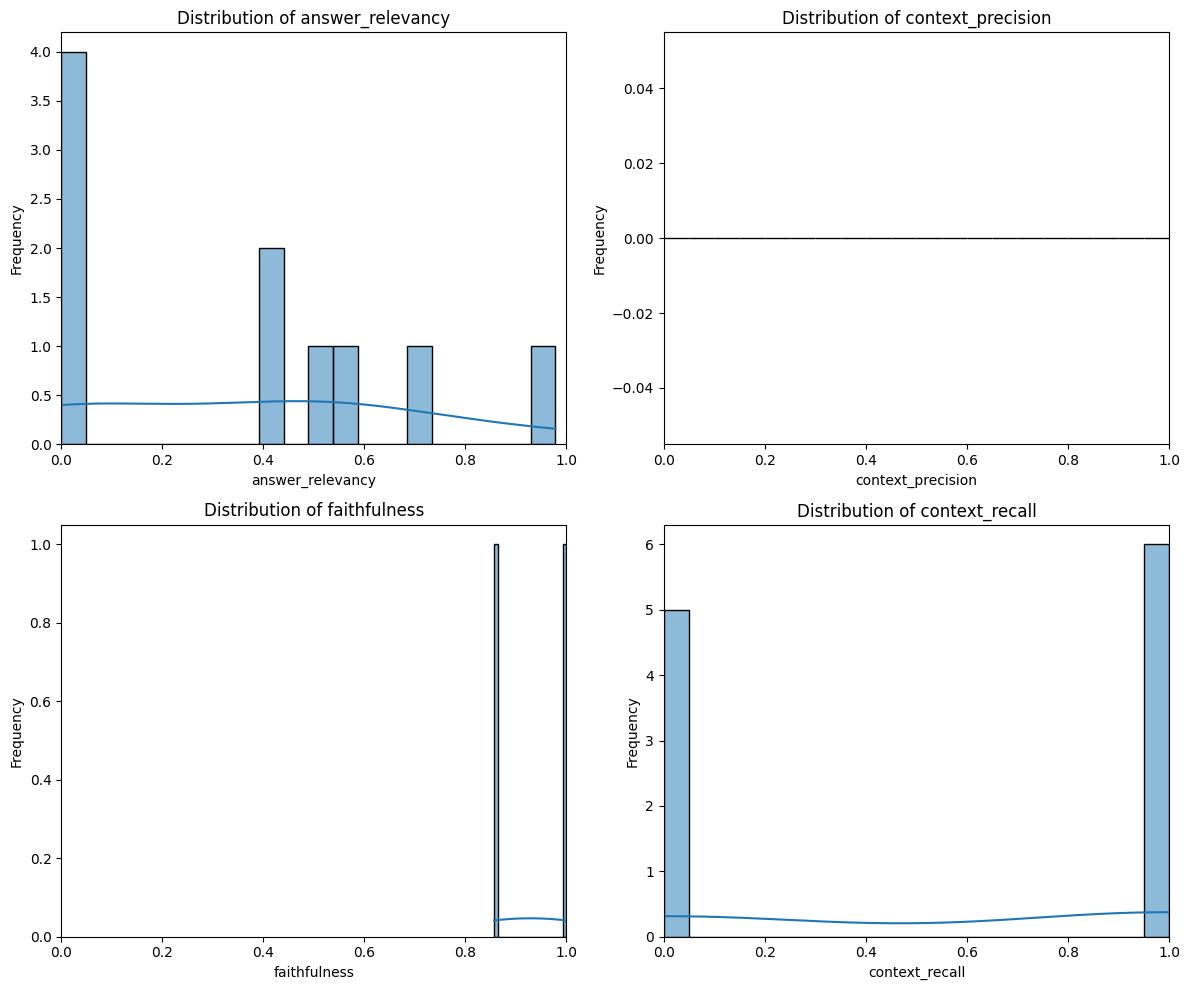

In [4]:
ratings_id = 17
rating, questions, scores = get_rating_data(ratings_id)
df_merged_10_15 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_10_15)

## Ollama

### 10 Dok

#### 15 Qestions

**17b59db2-19e5-4016-9afe-bb111d7d804f**  
Wie zu erwarten ist aufgrund der Sinnlosen Frage auch eine 0.0 Bewertung gegeben worden

In [29]:
get_entry_by_id(df_merged_10_15, "17b59db2-19e5-4016-9afe-bb111d7d804f")

{'id': '17b59db2-19e5-4016-9afe-bb111d7d804f',
 'question': 'Wie kann ich das tun?',
 'reference_answer': 'Sie erhalten nach Bestätigung und Versand Ihres Auftrags eine Bestätigungs-E-Mail mit Ihrer Tracking-Nummer. Klicken Sie einfach auf den im E-Mail enthaltenen Link oder besuchen Sie unsere Webseite für die Auftragsverfolgung, geben Sie dort Ihre Tracking-Nummer ein, um den Fortschritt Ihrer Sendung in Echtzeit zu verfolgen.',
 'response': "I don't know.",
 'reference_context': 'Document 80: Name Coach\tE-Mail Coach\n\n\t\n\n\t\n\n\t-------------------------------------------\t------------------------------------------------\n\n\tDatum, Ort\tUnterschrift Coach',
 'retrieved_contexts': ['Preise\n\n\n\n\n\n\n\nJe nach Inhalt variiert der Preis.',
  'Dritten eine diesem Vertrag entsprechende Verschwiegenheitspflicht aufzuerlegen.',
  '(3) Der Kunde verpflichtet sich, von d4f zum Zwecke des Zugangs zu dessen Diensten erhaltene Passwörter regelmäßig zu ändern und diese streng geheim zu 

**2aa4d1c2-ff43-4bad-b3c4-91602a5dbae1**  
Hier kommt es leider garnicht erst zu Problemen mit der Englischen vorgabe da der relevante Kontext erst garnicht gefunden wurde.

In [16]:
get_entry_by_id(df_merged_10_15, "2aa4d1c2-ff43-4bad-b3c4-91602a5dbae1")

[{'id': '2aa4d1c2-ff43-4bad-b3c4-91602a5dbae1',
  'question': 'Unter welchen Umständen kann der Anbieter den Vertrag kündigen, wenn das Unternehmen seine finanzwirtschaftlichen Ziele während des Stipendiums nicht erreicht?',
  'reference_answer': 'The provider may terminate the contract if the customer is in arrears with payments amounting to two monthly basic fees or if the customer breaches an essential contractual obligation and fails to remedy it after a reminder within a reasonable time. Any termination must be in written or qualified electronic form as per § 126a BGB.',
  'reference_context': 'Document 147: a)\tmit der Zahlung der Entgelte mit einem Betrag in Höhe von zwei monatlichen Grundentgelten in Verzug gerät\n\nb)\tschuldhaft gegen eine wesentliche Vertragspflicht verstößt, und der Kunde trotz Abmahnung innerhalb angemessener Frist nicht Abhilfe schafft.\n\n(4) Jede Kündigung bedarf zu ihrer Wirksamkeit der Schriftform oder alternativ der elektronischen Form des § 126a BGB

### 30 Questions

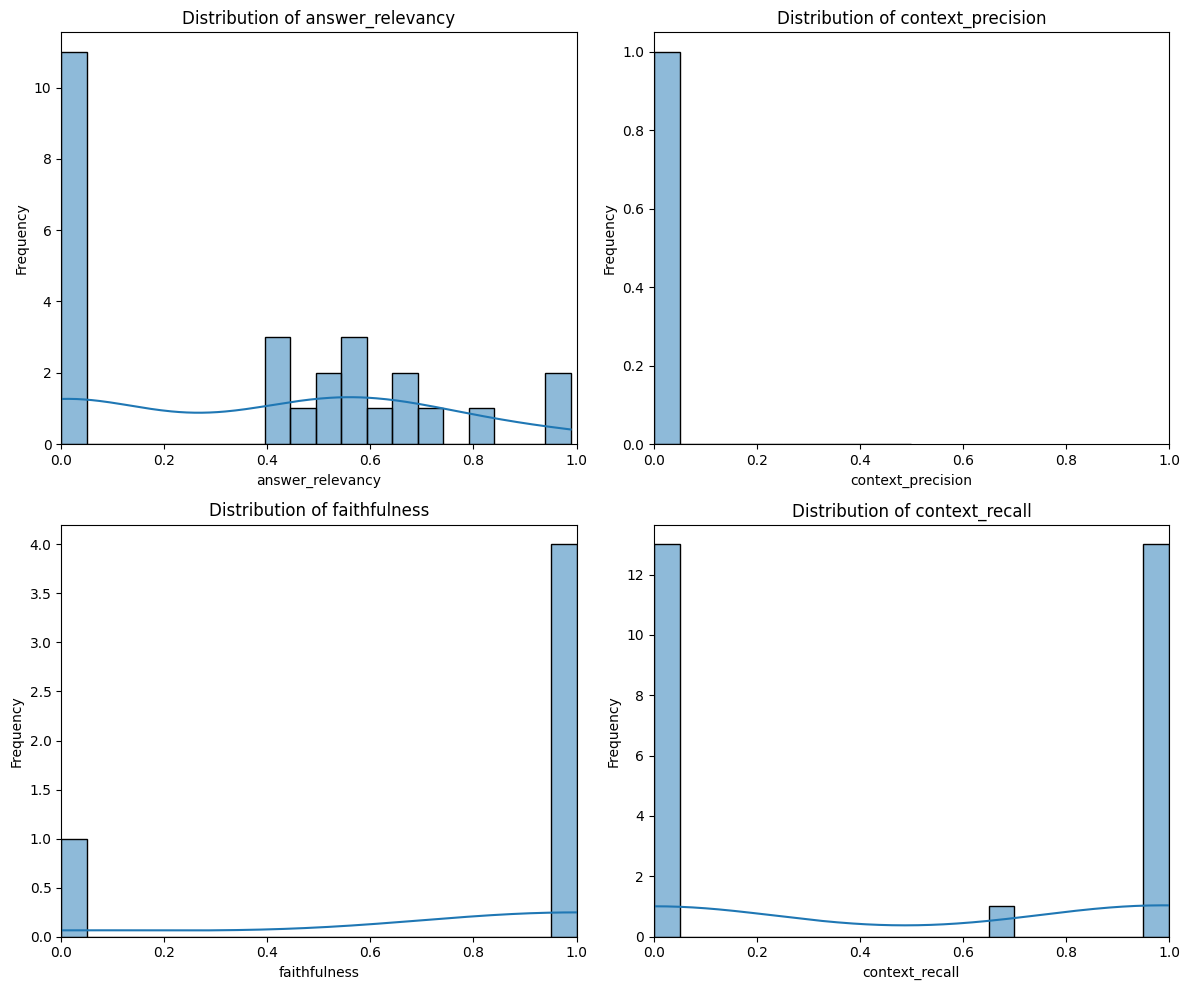

In [5]:
ratings_id = 18#10
rating, questions, scores = get_rating_data(ratings_id)
df_merged_10_30 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_10_30)

**c9c2a055-18bc-4697-bb52-d795f58976d3**  
Die scores sind wie zu erwarten, da der richtige Kontext nicht gefunden wurde.
Überraschent ist jedoch die faithtfullness, diese scheint 10 von 13 Behauptungen aus der Antwort mit dem Kontext belegen zu können.  
Das problem ist jedoch, dass die Antwort eigentlich "I don't know" ist und hier der "Denkprozess" mit in die Bewertung genommen wird.  
`10/13=0.7692307692`
`
[
  "April 2021",
  "Juli 2021",
  "August 2021",
  "November 2021",
  "Dezember 2021",
  "Januar 2022",
  "zwei Grundschulen",
  "monatliche Einnahmen von je 100 €",
  "§ 8 Preise und Zahlung",
  "Zahlungsmethoden",
  "Sicherheitsmaßnahmen für personenbezogene Daten",
  "Kundengewinnung",
  "Akquisitionsphasen"
]
`

In [20]:
get_entry_by_id(df_merged_10_30, "c9c2a055-18bc-4697-bb52-d795f58976d3")

[{'id': 'c9c2a055-18bc-4697-bb52-d795f58976d3',
  'question': 'Welche Zahlungsmethoden akzeptieren Sie?',
  'reference_answer': 'Wir akzeptieren eine Vielzahl von Zahlungsmethoden, darunter Kredit- und Debitkarten wie Visa, Mastercard, American Express und Discover. Zudem bieten wir die Möglichkeit zur Bezahlung mit digitalen Wallets wie PayPal und Google Pay sowie Überweisungen oder Einzelverrechnungen an.',
  'reference_context': 'Document 234: Online-Abwesenheitsanzeige oder die Möglichkeit brauchen, Dateien auf Ihrer Webseite hochzuladen.',
  'conversation_history': [],
  'metadata': {'question_type': 'simple',
   'seed_document_id': 234,
   'topic': '<think>\nOkay, so I need to figure out the best topic that represents all these documents. Let me start by reading through each document carefully.\n\nFirst document: It talks about a product called Infofuchs developed for schools without up-to-date websites. The system helps manage their entire website with an intuitive interface tai

**6cf759e5-d24b-45c5-9d0d-b2b62259b556**  
Context Recall ist gut, da das richtige Dokument gefunden wurde es ist jedoch fraglich, wieso die Antwort zu 54% relevant ist.

In [21]:
get_entry_by_id(df_merged_10_30, "6cf759e5-d24b-45c5-9d0d-b2b62259b556")

[{'id': '6cf759e5-d24b-45c5-9d0d-b2b62259b556',
  'question': 'Hallo! Ich bin Schulleiter/in und überlege, ob wir als Pilotenschule bei Develop 4 Future teilnehmen sollen. Könnt ihr mir sagen, wie viel weniger die beiden Pilotenschulen im ersten Jahr verdienen verglichen mit anderen Schulen?',
  'reference_answer': 'Die beiden Pilotenschulen verdienen im ersten Jahr 2.000€ weniger als die anderen Schulen.',
  'reference_context': 'Document 246: Da die ersten beiden Schulen Pilotschulen sind, bezahlen diese einen günstigeren Preis. Weitere Rabattaktionen sind nicht geplant. Die Preise sind über die Website von Develop 4 Future transparent einsehbar. \n\nIn dem ersten Jahr werden die beiden Pilotschulen dadurch 2.000€ weniger einbringen als die anderen Schulen.',
  'conversation_history': [],
  'metadata': {'question_type': 'situational',
   'seed_document_id': 246,
   'situational_context': "<think>\nOkay, let's see what the user is asking for here. They provided a German chatbot descri

**16cf7a01-59fc-42fa-8fd8-5de4e4830851**  
Zu erwarten nur 0 scores

In [22]:
get_entry_by_id(df_merged_10_30, "16cf7a01-59fc-42fa-8fd8-5de4e4830851")

[{'id': '16cf7a01-59fc-42fa-8fd8-5de4e4830851',
  'question': 'Hallo! Wir arbeiten gerade an einem Projekt mit Ihrer Schule und möchten wissen, welche Zahlungsmethoden Sie akzeptieren.',
  'reference_answer': 'Wir akzeptieren eine Vielzahl von Zahlungsmethoden, um unseren Kunden einen bequemen und sicheren Einkaufsprozess zu bieten. Sie können mit den großen Kredit- und Debitkarten wie Visa, Mastercard, American Express und Discover bezahlen. Zudem bieten wir die Möglichkeit, mit beliebten digitalen Wallets wie PayPal und Google Pay zu zahlen. Für eine zusätzliche Flexibilität können Sie auch eine Banküberweisung oder ein Einzugszugang verwenden.',
  'reference_context': 'Document 240: Die Schulen werden von Develop 4 Future nach einer Begutachtung der aktuellen Webpräsenz angerufen, anhand derer gut eingeschätzt werden kann, wie gut sich ein neues System verkaufen lässt. Um das Interesse anzufragen, wird bei dem Schulsekretariat mit der Bitte um Durchstellung an die Schulleitung anger

**fd1fbf6f-7db1-499d-9c45-500ff4a5fd77**  
Auch wenn ich zuerst dachte, dass die Antwort unnütz ist, zeigt sich hier, dass das RAG die Antwort nicht wirklich falsch beantwortet aber auch nicht die wirklich zu recht erwarete Antwort gibt

In [23]:
get_entry_by_id(df_merged_10_30, "fd1fbf6f-7db1-499d-9c45-500ff4a5fd77")

[{'id': 'fd1fbf6f-7db1-499d-9c45-500ff4a5fd77',
  'question': 'Für welche Zielgruppe wurde das entwickelte Produkt entwickelt?',
  'reference_answer': 'Das entwickelte Produkt ist für Grundschulen gedacht.',
  'reference_context': 'Document 183: Das System überzeugt durch seine einfache Bedienbarkeit und die damit einhergehende geringe Fehlerquote.\n\nDas entwickelte Produkt besteht aus einer kreierten Website für Grundschulen. Der Unique Selling Point besteht darin, dass die Website durch die BedienerInnen ohne großes technisches Know How selbstständig aktualisiert und bedient werden kann. Alles nach dem Prinzip „keep it simple“.',
  'conversation_history': [],
  'metadata': {'question_type': 'situational',
   'seed_document_id': 183,
   'situational_context': '<think>\nAlright, so I\'m trying to figure out how to respond to this user query. Let me break it down step by step.\n\nFirst, the user provided a German description of a chatbot for "Develop 4 Future." It\'s supposed to answer

**e21b7ef7-6a7c-4639-a093-a74350afafb9 & 6982d0b3-868d-4c6c-b850-af5c9e354a91**  
Wie zu erwarten 0 scores

In [24]:
get_entry_by_id(df_merged_10_30, "e21b7ef7-6a7c-4639-a093-a74350afafb9")

[{'id': 'e21b7ef7-6a7c-4639-a093-a74350afafb9',
  'question': 'Wieviel Auswahl haben Sie an Zahlungsmethoden, während sich das Produkt zur Marktreife entwickelt?',
  'reference_answer': 'Wir akzeptieren eine Vielzahl von Zahlungsmethoden, um unseren Kunden ein bequemes und sicheres Einkaufserlebnis zu bieten. Sie können mit den großen Kredit- und Debitkarten wie Visa, Mastercard, American Express und Discover bezahlen. Zudem bieten wir die Möglichkeit, mit beliebten digitalen Wallets wie PayPal und Google Pay zu zahlen. Für eine zusätzliche Flexibilität haben Sie die Option, Ihre Bestellung per Banküberweisung oder Überweisung zu bezahlen. Ganz sicherstellen wir uns, dass wir die Sicherheit Ihrer persönlichen Informationen priorisieren und alles tun, um sicherzustellen, dass Ihre Transaktionen sicher verarbeitet werden.',
  'reference_context': 'Document 61: 4a. Entwicklung der Geschäftsidee \n\n(In diesem Abschnitt soll die Umsetzung des Projektplans während des Stipendiums erläutert 

In [25]:
get_entry_by_id(df_merged_10_30, "6982d0b3-868d-4c6c-b850-af5c9e354a91")

[{'id': '6982d0b3-868d-4c6c-b850-af5c9e354a91',
  'question': 'Welche Zahlungsmethoden akzeptieren Sie?',
  'reference_answer': 'Wir akzeptieren Kredit- und Debitkarten wie Visa, Mastercard, American Express und Discover. Zudem unterstützen wir digitale Wallets wie PayPal und Google Pay sowie Banküberweisungen oder Einzelverrechnung.',
  'reference_context': 'Document 208: Das System ist nicht wie ein Webseitenbaukasten, wie z.B. Wordpress/Joomla, welche sehr frei in der Gestaltung sind, jedoch ein hohes Technisches Know-how voraussetzten. Auch ein Vergleich mit Systemen, die, wie z.B. der Schulmanager-online eine Schülerverwaltung anbieten, ist nicht richtig, da diese Systeme in Konkurrenz mit den vom Bundesland NRW zur Verfügung gestellten Systemen stehen (Logineo). Der Schulfuchs abstrahiert das System von Joomla sehr stark und bietet eine Integration mit den',
  'conversation_history': [],
  'metadata': {'question_type': 'simple',
   'seed_document_id': 208,
   'topic': '<think>\nO

### 100 Dok

#### 50 Questions

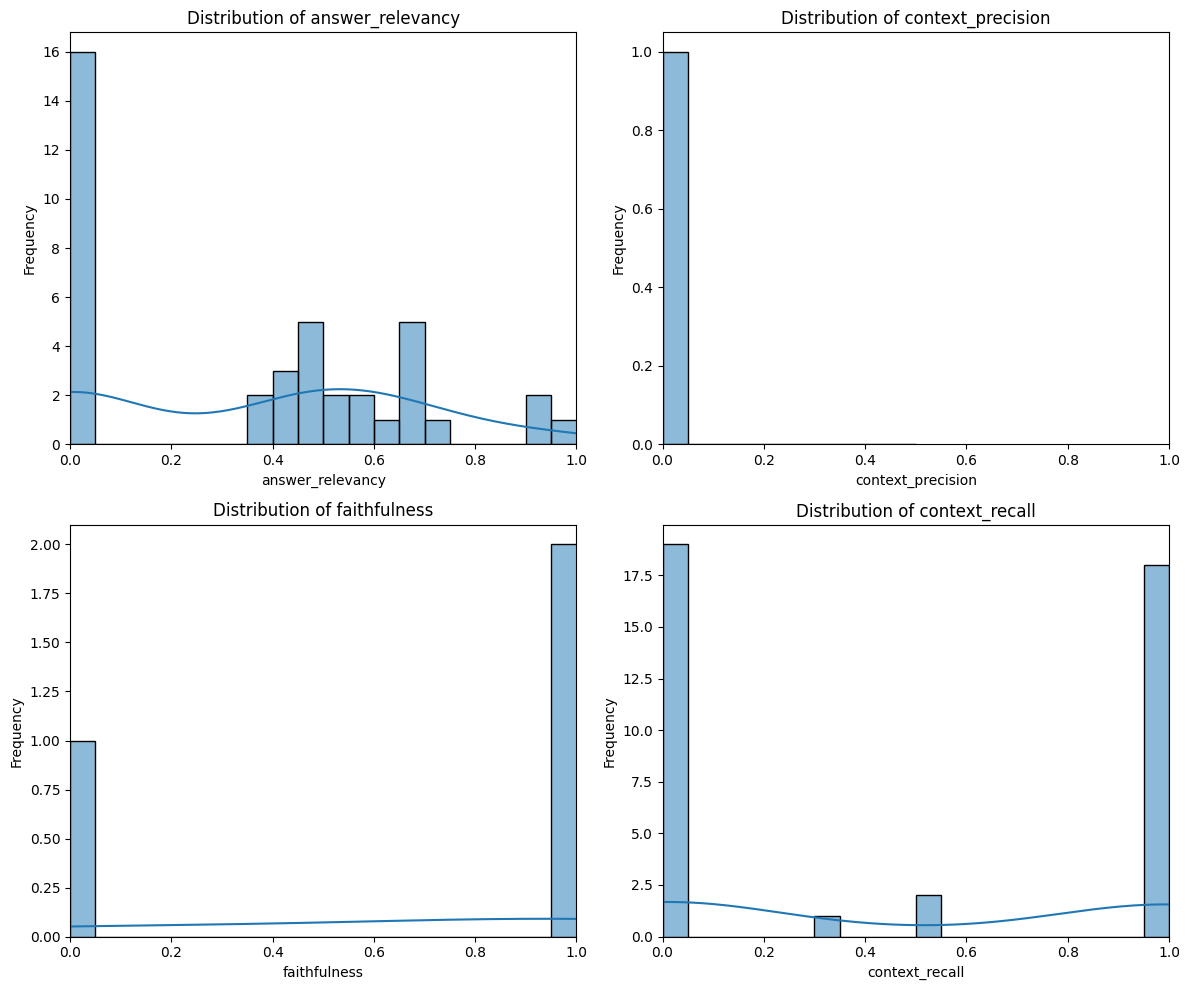

In [6]:
ratings_id = 19#10
rating, questions, scores = get_rating_data(ratings_id)
df_merged_100_50 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_100_50)

**15d9b836-f030-4af9-91ae-cb87844738cf**  
Die 0/Nan Bewertungen ergeben Sinn, die Frage ist etwas ungenau Formuliert und der eigentliche gewollte Kontext wird nicht gefunden, warum die relevancy jedoch 43% ist erschließt mich jedoch nicht

In [28]:
get_entry_by_id(df_merged_10_30, "15d9b836-f030-4af9-91ae-cb87844738cf")

[{'id': '15d9b836-f030-4af9-91ae-cb87844738cf',
  'question': 'Wie ist es?',
  'reference_answer': 'Den Schulen wird eine 99\u202f%-ige Verfügbarkeit der Webseite gewährt. Dadurch ist die Webseite sehr gut erreichbar und bei der branchenüblichen durchschnittlichen Verfügbarkeit.',
  'reference_context': 'Document 353: Den Schulen wird eine 99% Verfügbarkeit der Webseite gewährt. Dadurch ist die Webseite sehr gut erreichbar und bei der branchenüblichen durchschnittlichen Verfügbarkeit.\n\n\n\n\n\n\n\n2.3.4.2 Gründerteam und Schlüsselpersonen\n\nDocument 1148: Den Schulen wird eine 99% Verfügbarkeit der Webseite gewährt. Dadurch ist die Webseite sehr gut erreichbar und bei der Branchen durchschnittlichen Verfügbarkeit.\n\n\n\n2.3.3.3 Wissens- und Technologievorsprung\n\nDie verwendete Technologie Laravel erleichtert das Entwickeln, indem es einen Baukasten für häufig verwendete Bausteine zu Verfügung stellt. Mit dem Schulfuchst wurden diese Bausteine weiter auf Grundschulen angepasst, um

**2d94d490-7a3c-457b-b3e3-799f43599114**  
Weder die Frage noch die Antwort ergeben wirklich Sinn, weshalb hier also eine Bewertung von 0.46 für relevancy gegeben wird erschließt sich mir nicht.

In [29]:
get_entry_by_id(df_merged_10_30, "2d94d490-7a3c-457b-b3e3-799f43599114")

[{'id': '2d94d490-7a3c-457b-b3e3-799f43599114',
  'question': 'Hallo! Ich bin gerade dabei, die Unternehmensbeschreibung für unser Startup zu erstellen, aber ich habe noch nicht viel Fortschritt gemacht. Könntest du mir helfen, klarzumachen, was unsere innovative Geschäftsidee, die Umsetzung im Unternehmen und der adressierte Markt sind?',
  'reference_answer': 'Die Kurzbeschreibung kann für die Öffentlichkeitsarbeit des Zuwendungsgebers verwendet werden und soll die innovative Geschäftsidee, die Umsetzung im Unternehmen sowie den adressierten Markt beschreiben.',
  'reference_context': 'Document 690: Nein.\n\n  Ja, weil: Vom Coach ein mangelnder Vortschritt des Gründungsvorhabens festgestellt wurde.  \n\n\n\nKurzbeschreibung des Unternehmens \n\n(Die Kurzbeschreibung kann für die Öffentlichkeitsarbeit des Zuwendungsgebers verwendet werden. Es soll die innovative Geschäftsidee, die Umsetzung im Unternehmen und der adressierte Markt beschrieben werden.)\n\n\n\n(Textumfang ca. ½ Seite, S

#### 100 Questions

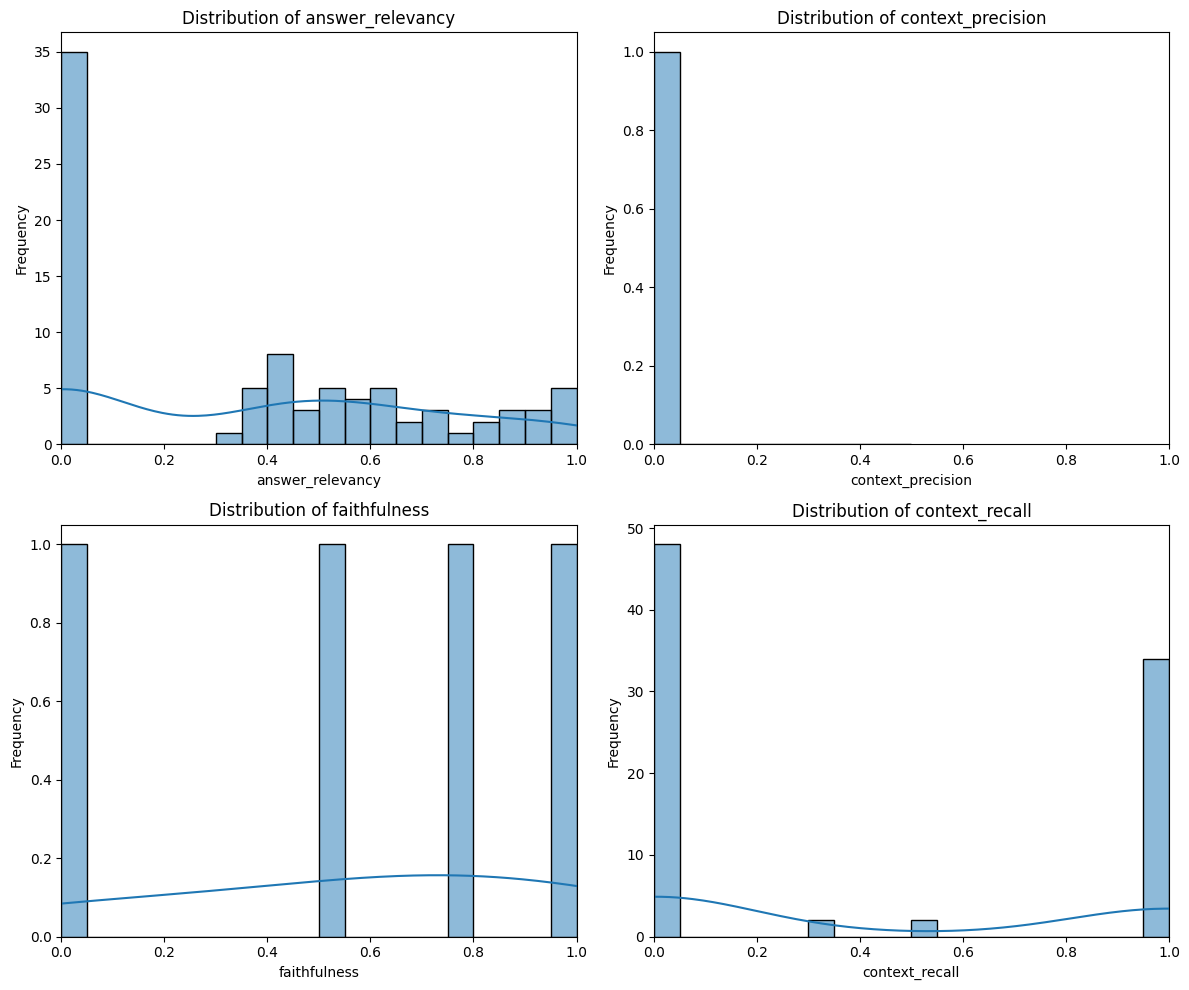

In [7]:
ratings_id = 20#10
rating, questions, scores = get_rating_data(ratings_id)
df_merged_100_100 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_100_100)

**e22babed-09df-4f52-80d1-104347957337**  
Die Frage war ungenau und alles bis auf die relevancy ist 0/Nan  
Die Frage ist an sich nicht falsch beantwortet worden im Hinblick auf die gewollte Antwort jedoch schon

In [32]:
get_entry_by_id(df_merged_10_30, "e22babed-09df-4f52-80d1-104347957337")

[{'id': 'e22babed-09df-4f52-80d1-104347957337',
  'question': 'Wie hoch ist die Gesamtsumme der Passiva?',
  'reference_answer': 'Die Summe der Passiva beträgt 185\u202f000 EUR.',
  'reference_context': 'Document 117: Kategorie: Passiva\nUnterkategorie: Jahresüberschuss\nBetrag (EUR): 15000\n\nDocument 131: Kategorie: Passiva\nUnterkategorie: Jahresüberschuss\nBetrag (EUR): 22000\n\nDocument 134: Kategorie: Passiva\nUnterkategorie: Sonstige Verbindlichkeiten\nBetrag (EUR): 14000\n\nDocument 122: Kategorie: Summe Passiva\nUnterkategorie: \nBetrag (EUR): 185000',
  'conversation_history': [],
  'metadata': {'question_type': 'simple',
   'seed_document_id': 117,
   'topic': '<think>\nOkay, so I need to figure out the best topic that represents all these documents. Let me start by reading through each document carefully.\n\nFirst, looking at the categories mentioned: Hardware, Vertrieb, Aktiva, Sonstiges, Marketing, Gesamtkosten, Personal, Passiva. These seem like different sections of a b

**c746fa63-9efb-4cb1-822d-3384aa81ec68**  
Die relevanten Dokumente wurden nicht gefunden

In [33]:
get_entry_by_id(df_merged_10_30, "c746fa63-9efb-4cb1-822d-3384aa81ec68")

[{'id': 'c746fa63-9efb-4cb1-822d-3384aa81ec68',
  'question': 'Which milestones were adjusted in the plan until February 1, 2021?',
  'reference_answer': 'The milestones adjusted until February 1, 2021 include Coaching-Beginn + Gründung, Businessplan und Programmierung, and Außenauftritt und Vertragsgestaltung. These milestones were moved to April 1, 2021; May 1, 2021; and April 1, 2021 respectively.',
  'reference_context': 'Document 737: DATUM MEILENSTEIN POSITION BASISPLAN Angepasste Position Angepasstes Datum Angepasster Meilenstein Bis 2021-02-01 00:00:00 Coaching-Beginn + Gründung 40 0 40 2021-02-01 00:00:00 Coaching-Beginn + Gründung 2021-04-01 00:00:00 Businessplan und Programmierung -5 0 15 2021-05-01 00:00:00 Außenauftritt und Vertragsgestaltung 2021-05-01 00:00:00 Außenauftritt und Vertragsgestaltung 15 0 -5 2021-04-01 00:00:00 Businessplan und Programmierung 2021-06-01 00:00:00 Fertiges MVP + Beta-Tester 0 5\n\nDocument 774: DATUM MEILENSTEIN POSITION BASISPLAN Angepasste P

**1a322c0b-4b65-4290-87fe-83bce09ccadf**  
Erwartet komplettes Versagen

In [34]:
get_entry_by_id(df_merged_10_30, "1a322c0b-4b65-4290-87fe-83bce09ccadf")

[{'id': '1a322c0b-4b65-4290-87fe-83bce09ccadf',
  'question': 'Wie können Kunden Rückmeldungen oder Verbesserungsvorschläge abgeben?',
  'reference_answer': 'Kunden können Verbesserungsvorschläge in Punkt 3 und weitere Anmerkungen in Punkt 5 hinterlegen.',
  'reference_context': 'Document 68: 3. Haben Sie Verbesserungsvorschläge?\n__________________________________________________________\n\n4. Wie empfinden Sie die Unterstützung durch das Projektteam?\n[ ] Sehr gut  [ ] Gut  [ ] Befriedigend  [ ] Ausreichend  [ ] Mangelhaft\n\n5. Weitere Anmerkungen:\n__________________________________________________________',
  'conversation_history': [],
  'metadata': {'question_type': 'complex',
   'seed_document_id': 68,
   'topic': '<think>\nOkay, so I need to figure out the best topic that represents all these documents in German. Let me start by reading through each document carefully.\n\nFirst, there\'s a list of todos and dates related to schools, like "Todo Listen für Schulen" and mentions 

**22b5bf6e-f260-434a-9938-ac64a80bc014**  
Ich würde der Antwort eine 100% geben

In [35]:
get_entry_by_id(df_merged_10_30, "22b5bf6e-f260-434a-9938-ac64a80bc014")

[{'id': '22b5bf6e-f260-434a-9938-ac64a80bc014',
  'question': 'Hallo, ich bin ein kanadischer Student, der sich für die Schulsysteme in Deutschland interessiert. Könntest du mir erklären, warum sich die meisten Grundschulen in NRW befinden?',
  'reference_answer': 'Die meisten Grundschulen befinden sich in NRW, damit sie das vom Bundesland zur Verfügung gestellte System Logineo einbinden können, das Lehrer- und Schülerverwaltung bietet.',
  'reference_context': 'Document 361: Die meisten Grundschule befinden sich zudem auch in NRW, dies bietet die Möglichkeit das vom Bundesland zu verfügte gestellte System (Logineo) einzubinden.\n\nLogineo stellt eine Lehrer- und Schülerverwaltung zu Verfügung. Weitere Informationen über Logineo und dessen Funktionen finden Sie hier.\n\n\n\n2.3.6 Marketing und Vertrieb\n\nDocument 1175: Die Meisten Grundschule befinden sich zudem auch in NRW, dies bietet die Möglichkeit das vom Bundesland zu verfügte gestellte System (Logineo) anzubinden.\n\nDiese biet

### 400 Dok

#### 150 Questions

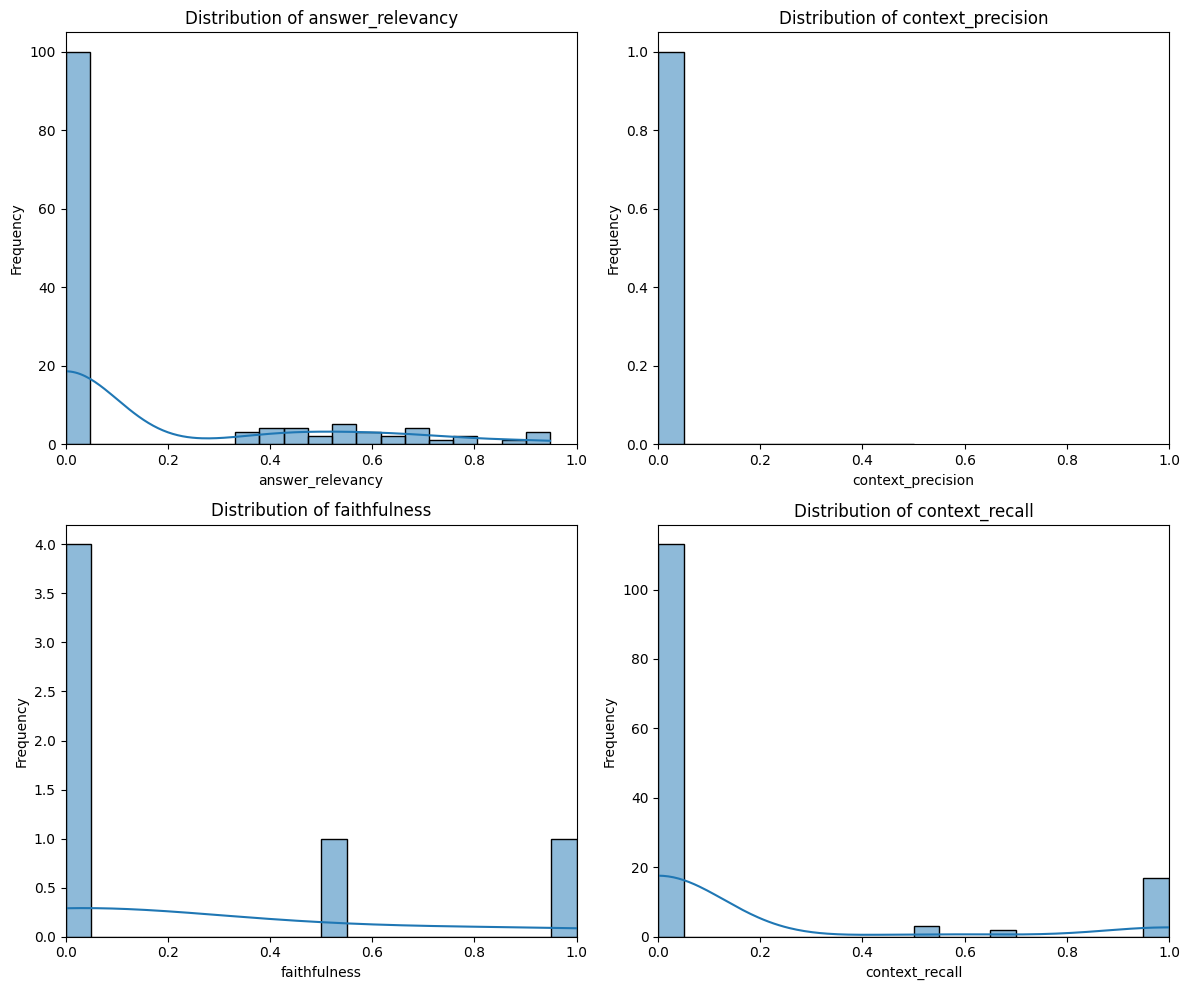

In [8]:
ratings_id = 21#10
rating, questions, scores = get_rating_data(ratings_id)
df_merged_400_150 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_150)

**9bb91345-06bc-4472-9518-6179603a4fe9**  
Verdiente relevancy

In [37]:
get_entry_by_id(df_merged_10_30, "9bb91345-06bc-4472-9518-6179603a4fe9")

[{'id': '9bb91345-06bc-4472-9518-6179603a4fe9',
  'question': 'Wie ist die Vorgehensweise bei der Speicherung von Dokumenten und Quellcode-Dokumentation innerhalb des Unternehmens?',
  'reference_answer': 'Die Dokumentation des Quellcodes liegt in Gitlab zusammen mit dem eigentlichen Quellcode.',
  'reference_context': 'Document 4645: Die Dokumente werden in der Cloud von Microsoft liegen, da mit Microsoft Office gearbeitet wird. Die Dokumentation des Quellcodes liegt jedoch in Gitlab zusammen mit dem eigentlichen Quellcode.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDurch das entwickelte Produkt infofuchs sind die Grundschulen eigenständig dazu in der Lage, Informationen auf der Homepage zu bearbeiten. Dies ermöglicht ihnen, ohne technisches Know-How, ihre eigene Web-Präsenz zu verwalten.\n\nDocument 5483: Die Dokumente werden in der Cloud von Microsoft liegen da mit Microsoft Office gearbe

**c294170e-8fa3-47a0-b1d6-9ad40dfe90b7**  
Erwartet, komplett 0

In [38]:
get_entry_by_id(df_merged_10_30, "c294170e-8fa3-47a0-b1d6-9ad40dfe90b7")

[{'id': 'c294170e-8fa3-47a0-b1d6-9ad40dfe90b7',
  'question': 'Wie viele Zahlungsmethoden akzeptieren Sie?',
  'reference_answer': 'Wir akzeptieren zahlreiche Zahlungsmethoden wie Kredit- und Debitkarten (Visa, Mastercard, American Express, Discover) sowie digitale Wallets (PayPal, Google Pay).',
  'reference_context': 'Document 2855: 9.0")>0,J=Y&&Y.indexOf("edge/")>0,Z=(Y&&Y.indexOf("android"),Y&&/iphone|ipad|ipod|ios/.test(Y)||"ios"===V),tt=(Y&&/chrome\\/\\d+/.test(Y),Y&&/phantomjs/.test(Y),Y&&Y.match(/firefox\\/(\\d+)/)),et={}.watch,nt=!1;if($)try{var rt={};Object.defineProperty(rt,"passive",{get:function(){nt=!0}}),window.addEventListener("test-passive",null,rt)}catch(r){}var ot=function(){return void 0===U&&(U=!$&&!G&&void',
  'conversation_history': [],
  'metadata': {'question_type': 'double',
   'original_questions': [{'question': 'Wie viele Zahlungsmethoden akzeptieren Sie?',
     'answer': 'Wir akzeptieren eine Vielzahl von Zahlungsmethoden, um unseren Kunden ein bequemes und

**b280874b-4563-47ca-a58d-aa854e393e3b & dfbef40d-cef6-4f2d-b72e-e7010d998968**  
Erwartet 0

In [39]:
get_entry_by_id(df_merged_10_30, "b280874b-4563-47ca-a58d-aa854e393e3b")

[{'id': 'b280874b-4563-47ca-a58d-aa854e393e3b',
  'question': 'Wie kann ich meinen Auftrag verfolgen? Bitte nennen Sie mir die Schritte, um den Status meines Auftrags zu überprüfen, einschließlich der Verwendung eines Bestätigungsemails oder Tools auf Ihrer Website. Gibt es außerdem weitere Methoden oder Informationen, die mir helfen können, den Lieferungfortschritt besser zu verfolgen?',
  'reference_answer': 'Sie können Ihren Auftrag problemlos verfolgen! Nachdem Ihr Kauf erfolgreich bestätigt und versandt wurde, erhalten Sie eine Bestätigungs-E-Mail mit Ihrer Tracking-Nummer. Klicken Sie einfach auf den im E-Mail enthaltenen Link oder besuchen Sie die Verfolgungsseite unserer Website. Geben Sie Ihre Tracking-Nummer ein, und Sie können den Fortschritt Ihres Sendungsempfangs quasi in Echtzeit verfolgen. Auf diese Weise bleiben Sie über den geschätzten Liefertermin informiert und können sicherstellen, dass Sie verfügbar sind, um Ihren Packet zu empfangen.',
  'reference_context': 'Docu

In [40]:
get_entry_by_id(df_merged_10_30, "dfbef40d-cef6-4f2d-b72e-e7010d998968")

[{'id': 'dfbef40d-cef6-4f2d-b72e-e7010d998968',
  'question': 'Hallo! Ich bin ein kanadischer Student, der bald nach Europa gehen wird. Könntest du mir sagen, wie viele Menschen momentan in Frankreich leben?',
  'reference_answer': 'Wir akzeptieren eine Vielzahl von Zahlungsmethoden, um unseren Kunden ein bequemes und sicheres Einkaufserlebnis zu bieten. Sie können mit den großen Kredit- und Debitkarten wie Visa, Mastercard, American Express und Discover bezahlen. Zudem bietet uns die Möglichkeit, mit beliebten digitalen Wallets wie PayPal und Google Pay zu zahlen. Für eine zusätzliche Flexibilität haben Sie die Option, Ihre Bestellung über Banküberweisung oder Einzelverrechnung zu bezahlen.',
  'reference_context': 'Document 2451: "),e("th",[this._v("Listeners")]),this._v(" "),e("th")])])},function(){var t=this.$createElement,e=this._self._c||t;return e("thead",[e("tr",[e("th",[this._v("Key")]),this._v(" "),e("th",[this._v("Action")]),this._v(" "),e("th")])])},function(){var t=this.$c

**df224a69-801b-4bdd-b826-f885ab741b40**  
Nachvollziehbar, dass hier alles außer dem context-recall 0/Nan ist

In [41]:
get_entry_by_id(df_merged_10_30, "df224a69-801b-4bdd-b826-f885ab741b40")

[{'id': 'df224a69-801b-4bdd-b826-f885ab741b40',
  'question': 'Is there any?',
  'reference_answer': 'No, the context contains only JavaScript code without any applicable information.',
  'reference_context': 'Document 74: this.resizeCanvas.focus();\n\n            return true;\n        };\n\n        // update the canvas after the resizing\n        this.refresh = function () {\n            if (!this.resizeCanvas.getContext) {\n                return;\n            }',
  'conversation_history': [{'role': 'user',
    'content': 'I want to know if there is relevant information in this context.'},
   {'role': 'assistant', 'content': 'How can I help you with that?'}],
  'metadata': {'question_type': 'conversational',
   'seed_document_id': 74,
   'topic': '<think>\nOkay, so I need to figure out the best topic that represents all these documents. Let me start by reading through each document carefully.\n\nLooking at the first document, it has code snippets like "this.resizeCanvas.focus();" and

#### 300 Questions

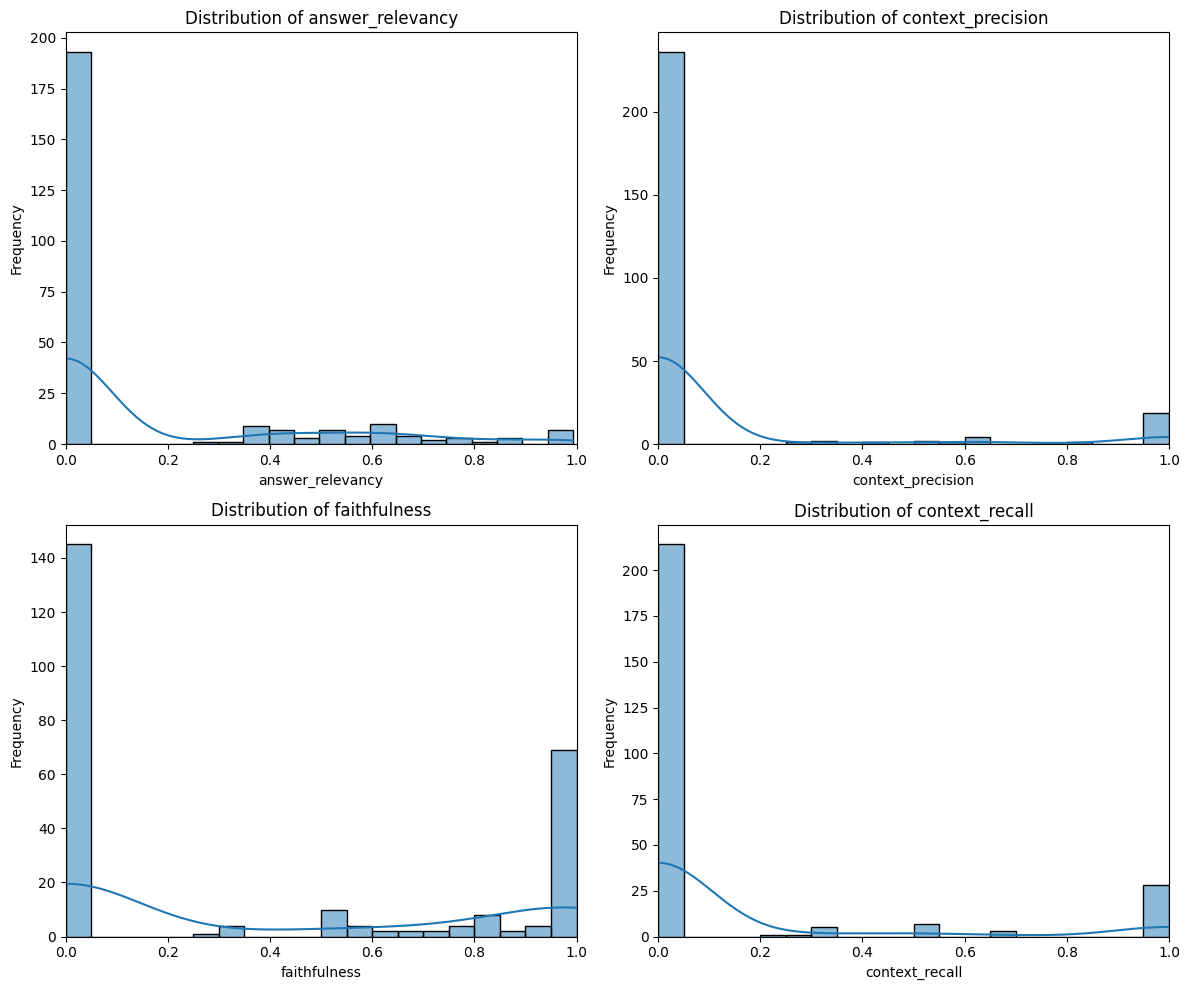

In [9]:
ratings_id =33
rating, questions, scores = get_rating_data(ratings_id)
df_merged_400_300 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_300)

**ca83c38c-be8a-468c-97e3-c3f1da80ccdc**  
Erwartet 0.0

In [5]:
get_entry_by_id(df_merged_400_300, "ca83c38c-be8a-468c-97e3-c3f1da80ccdc")

{'id': 'ca83c38c-be8a-468c-97e3-c3f1da80ccdc',
 'question': 'How much does it cost?',
 'reference_answer': 'For orders under $50, shipping costs $5.99.',
 'response': "I don't know.",
 'reference_context': 'Document 1770: #efefef!important}.border-0{border:0!important}.border-top-0{border-top:0!important}.border-right-0{border-right:0!important}.border-bottom-0{border-bottom:0!important}.border-left-0{border-left:0!important}.border-primary{border-color:#adadff!important}.border-secondary{border-color:#494444!important}.border-success{border-color:#1f9d55!important}.border-info{border-color:#1c3d5a!important}.border-warning{border-color:#684f1d!important}.border-danger{border-color:#621b18!important}.border-ligh\n\nDocument 2195: #efefef!important}.border-0{border:0!important}.border-top-0{border-top:0!important}.border-right-0{border-right:0!important}.border-bottom-0{border-bottom:0!important}.border-left-0{border-left:0!important}.border-primary{border-color:#4040c8!important}.borde

**5a8a61fc-4b29-4961-a727-bf07605db7c6**  
Wie zu erwarten 0/none

In [6]:
get_entry_by_id(df_merged_400_300, "5a8a61fc-4b29-4961-a727-bf07605db7c6")

{'id': '5a8a61fc-4b29-4961-a727-bf07605db7c6',
 'question': "Welche Funktionen aus 'vuex' werden in den bereitgestellten Codeausschnitten importiert?",
 'reference_answer': 'Die importierten Funktionen sind mapActions, mapGetters und mapMutations.',
 'response': "I don't know.",
 'reference_context': 'Document 302: <script>\nimport {mapActions, mapGetters, mapMutations} from \'vuex\'\nimport draggable from \'vuedraggable\'\n\nDocument 461: <script>\nimport {mapActions, mapGetters, mapMutations} from "vuex";\nimport draggable from \'vuedraggable\'\n\nDocument 475: <script>\nimport {mapActions, mapGetters, mapMutations} from "vuex";\nimport helpers from "@/helpers";\nimport draggable from "vuedraggable";\n\nDocument 224: <script>\nimport {mapActions, mapGetters} from \'vuex\'',
 'retrieved_contexts': ['Als Technologien für das System werden Laravel und Vue verwendet. Laravel und Vue sind in der Industrie weit verbreitet und gelten als zuverlässig und gut gewartet.\n\nVue wird verwendet, 

**57e43087-fb2b-4cbc-a29b-79edeefdb71b**  


In [7]:
get_entry_by_id(df_merged_400_300, "57e43087-fb2b-4cbc-a29b-79edeefdb71b")

{'id': '57e43087-fb2b-4cbc-a29b-79edeefdb71b',
 'question': 'Who receives the allocation and who is responsible for the project?',
 'reference_answer': 'The recipient of the allocation is Forschungszentrum Jülich GmbH, and the project carrier is Projektträger Jülich (PtJ).',
 'response': 'The individual described is responsible for leading and coordinating the "KI-Schulassistent" pilot project. They manage various aspects including communication with stakeholders, organizing training, monitoring milestones and budget, and documentation. Therefore, they are both responsible for the project and handle the allocation, likely receiving it as part of their role.\n\nAnswer: The person described is responsible for the project and handles the allocation as part of their leadership role.',
 'reference_context': 'Document 4481: Anlage 1 zum Zuwendungsbescheid \nFörderkennzeichen: \nPtJ-Projektnummer: \n(Zuwendungsempfänger) \nForschungszentrum Jülich GmbH \nProjektträger Jülich (PtJ) \nBereich T

**8f2f5dfb-071c-4ba3-a8e3-ccb83b440f5c**  


In [8]:
get_entry_by_id(df_merged_400_300, "8f2f5dfb-071c-4ba3-a8e3-ccb83b440f5c")

{'id': '8f2f5dfb-071c-4ba3-a8e3-ccb83b440f5c',
 'question': 'Was meinen Sie damit?',
 'reference_answer': 'Wir akzeptieren eine Vielzahl von Zahlungsmethoden, um unseren Kunden einen bequemen und sicheren Einkaufsprozess zu bieten. Sie können mit den großen Kredit- und Debitkarten wie Visa, Mastercard, American Express und Discover bezahlen. Zudem bietet uns die Option, mit beliebten digitalen Wallets wie PayPal und Google Pay zu zahlen. Für eine zusätzliche Flexibilität haben Sie die Möglichkeit, Ihre Bestellung über Banküberweisung oder Einzelverrechnung abzuschließen. Seien Sie versichert, dass wir die Sicherheit Ihrer persönlichen Daten priorisieren und alles in unserer Macht Stehende tun, um Ihre Transaktionen sicher zu verarbeiten.',
 'response': "I don't know",
 'reference_context': 'Document 2037: 1.5rem;margin-bottom:0;font-size:.83125rem;color:#6c757d;white-space:nowrap}.dropdown-item-text{display:block;padding:.25rem 1.5rem;color:#212529}.btn-group,.btn-group-vertical{positi

In [15]:
path = '/Users/leonbartz/develop/uni/rag-eval/bachelor/data/testset-eval/ollama/'

with open(path + 'o-15.json', 'r') as f:
    random_questions_10_15 = json.load(f)

with open(path + 'o-30.json', 'r') as f:
    random_questions_10_30 = json.load(f)

with open(path + 'o-50.json', 'r') as f:
    random_questions_100_50 = json.load(f)

with open(path + 'o-100.json', 'r') as f:
    random_questions_100_100 = json.load(f)

with open(path + 'o-150.json', 'r') as f:
    random_questions_400_150 = json.load(f)

with open(path + 'o-300.json', 'r') as f:
    random_questions_400_300 = json.load(f)

In [145]:
#'592dd699-80bf-4487-8ba6-d1ab1caeeae7',
# '1641cf7a-ecf3-4cee-807a-583f9bce5f40',
# '2c445c9f-66c8-4cec-803f-fab656f9d4bc',
# 'a5abd219-ea65-4c50-bc33-14f0e36cb19c',
# '1a969553-3bba-4b58-9ad2-549b766c754d',
# 'a35ca961-2bd7-443d-be84-f532431d6ebb',
# '4c2a185b-f53e-4cc7-9300-c22a463c8b8d',
# '2aa4d1c2-ff43-4bad-b3c4-91602a5dbae1',
# '17b59db2-19e5-4016-9afe-bb111d7d804f',
# '4fc2c118-fb0e-419a-a7ed-f53059dc26e6'

ratings_10_15 = [
    {
        'id': '592dd699-80bf-4487-8ba6-d1ab1caeeae7',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '1641cf7a-ecf3-4cee-807a-583f9bce5f40',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '2c445c9f-66c8-4cec-803f-fab656f9d4bc',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'a5abd219-ea65-4c50-bc33-14f0e36cb19c',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '1a969553-3bba-4b58-9ad2-549b766c754d',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'a35ca961-2bd7-443d-be84-f532431d6ebb',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '4c2a185b-f53e-4cc7-9300-c22a463c8b8d',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": None,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '2aa4d1c2-ff43-4bad-b3c4-91602a5dbae1',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '17b59db2-19e5-4016-9afe-bb111d7d804f',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '4fc2c118-fb0e-419a-a7ed-f53059dc26e6',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
]

In [146]:
# c9c2a055-18bc-4697-bb52-d795f58976d3
# 1296793c-848c-46b9-9ea6-d4de03f0b379
# 6cf759e5-d24b-45c5-9d0d-b2b62259b556
# e118dc28-c7a2-4c15-b7e6-e44e0b0b678a
# 14baa39c-4ae2-43f6-8d1e-7a67c48ec42e
# 16cf7a01-59fc-42fa-8fd8-5de4e4830851
# fd1fbf6f-7db1-499d-9c45-500ff4a5fd77
# 0ecdab63-2d23-4ba1-b474-8ddf04080ae6
# e21b7ef7-6a7c-4639-a093-a74350afafb9
# 6982d0b3-868d-4c6c-b850-af5c9e354a91

ratings_10_30 = [
    {
        'id': 'c9c2a055-18bc-4697-bb52-d795f58976d3',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '1296793c-848c-46b9-9ea6-d4de03f0b379',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": False, #should be higher
        "should_be_higher": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '6cf759e5-d24b-45c5-9d0d-b2b62259b556',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'e118dc28-c7a2-4c15-b7e6-e44e0b0b678a',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '14baa39c-4ae2-43f6-8d1e-7a67c48ec42e',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": False, #should be higher
        "should_be_higher": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '16cf7a01-59fc-42fa-8fd8-5de4e4830851',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'fd1fbf6f-7db1-499d-9c45-500ff4a5fd77',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '0ecdab63-2d23-4ba1-b474-8ddf04080ae6',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": False, #should be higher
        "should_be_higher": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'e21b7ef7-6a7c-4639-a093-a74350afafb9',
        'valid_question': False,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '6982d0b3-868d-4c6c-b850-af5c9e354a91',
        'valid_question': False,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
]

In [147]:
# 15d9b836-f030-4af9-91ae-cb87844738cf
# 1e934c5a-b00a-44ba-ad24-e78ef74db4ba
# 609f2e8e-98a4-40dd-8ba2-4983fde94855
# 2d94d490-7a3c-457b-b3e3-799f43599114
# 8d8a24fe-2aca-4a76-8bdf-6f728fce13fa
# c3be07d1-44f5-4c56-9a24-f7dd7b1e6a40
# 9e7c54e6-4fb6-467e-a310-c45f4d1b8f4a
# 8f7dcba9-b486-4155-bd07-0212af7fa480
# 3a8846a7-402b-4554-844c-df36eb922cce
# b134b3dc-11b5-4897-88cc-3cc4aff22725

ratings_100_50 = [
    {
        'id': '15d9b836-f030-4af9-91ae-cb87844738cf',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '1e934c5a-b00a-44ba-ad24-e78ef74db4ba',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '609f2e8e-98a4-40dd-8ba2-4983fde94855',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": False, #should be higher
        "should_be_higher": True,
        "context_precision": None,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '2d94d490-7a3c-457b-b3e3-799f43599114',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '8d8a24fe-2aca-4a76-8bdf-6f728fce13fa',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'c3be07d1-44f5-4c56-9a24-f7dd7b1e6a40',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '9e7c54e6-4fb6-467e-a310-c45f4d1b8f4a',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '8f7dcba9-b486-4155-bd07-0212af7fa480',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '3a8846a7-402b-4554-844c-df36eb922cce',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'b134b3dc-11b5-4897-88cc-3cc4aff22725',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
]

In [148]:
# 9a3b82bc-620b-4a9e-83fa-bb6d184e3b3a
# e22babed-09df-4f52-80d1-104347957337
# 735b164a-99bb-452c-bcbc-0659c38c1ccf
# c746fa63-9efb-4cb1-822d-3384aa81ec68
# f6cf8a97-43bb-4b97-86af-d5758afb1d9e
# 202f32f7-93ca-46a2-8627-935006df2939
# b23503c0-0e0d-4a6b-92b1-fefedb551549
# d423dff6-c5bb-48b7-af79-e47d654af561
# 1a322c0b-4b65-4290-87fe-83bce09ccadf
# 22b5bf6e-f260-434a-9938-ac64a80bc014

ratings_100_100 = [
    {
        'id': '9a3b82bc-620b-4a9e-83fa-bb6d184e3b3a',
        'valid_question': False,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'e22babed-09df-4f52-80d1-104347957337',
        'valid_question': False,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '735b164a-99bb-452c-bcbc-0659c38c1ccf',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'c746fa63-9efb-4cb1-822d-3384aa81ec68',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'f6cf8a97-43bb-4b97-86af-d5758afb1d9e',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '202f32f7-93ca-46a2-8627-935006df2939',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'b23503c0-0e0d-4a6b-92b1-fefedb551549',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'd423dff6-c5bb-48b7-af79-e47d654af561',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '1a322c0b-4b65-4290-87fe-83bce09ccadf',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '22b5bf6e-f260-434a-9938-ac64a80bc014',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
]

In [149]:
ratings_400_150 = [
    {
        'id': 'd94a8158-a048-40a0-82d9-c24d2611a159',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '8188656f-9f45-4cee-a3ec-43e90b273a69',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '217a65a9-9ef4-4361-9ea7-6ab95875b272',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '9bb91345-06bc-4472-9518-6179603a4fe9',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'c294170e-8fa3-47a0-b1d6-9ad40dfe90b7',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'b280874b-4563-47ca-a58d-aa854e393e3b',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'c1588c94-b4b3-43fe-8720-f6a3ba985aa0',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'dfbef40d-cef6-4f2d-b72e-e7010d998968',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': 'f224a69-801b-4bdd-b826-f885ab741b40',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
    {
        'id': '1f84c650-cc42-4f8e-99da-f56b56fd8623',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": None,
        "faithfulness": None,
        "context_recall": True,
    },
]

In [150]:
ratings_400_300 = [
    {
        'id': 'ca83c38c-be8a-468c-97e3-c3f1da80ccdc',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '5a8a61fc-4b29-4961-a727-bf07605db7c6',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '57e43087-fb2b-4cbc-a29b-79edeefdb71b',
        'valid_question': True,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '26321184-53da-48ec-8cc5-536bc8045713',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '8f2f5dfb-071c-4ba3-a8e3-ccb83b440f5c',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": None,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': 'e7cbbb3a-9420-4077-8530-f993f0693d1f',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '4201fb14-39f4-4175-854a-1533a2447567',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": False,
        "context_precision": True,
        "faithfulness": False,
        "context_recall": True,
    },
    {
        'id': '6663c98a-e2f0-42dd-80bf-da5f303f509e',
        'valid_question': True,
        'valid_answer': True,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '41f15187-108e-4d70-8e88-689d09936cff',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": True,
        "context_recall": True,
    },
    {
        'id': '518200fc-7180-422f-bb34-04f217b9e3c2',
        'valid_question': False,
        'valid_answer': False,
        "answer_relevancy": True,
        "context_precision": True,
        "faithfulness": False,
        "context_recall": True,
    },
]

In [151]:
from collections import Counter
from itertools import chain

all_ratings = list(chain(ratings_400_300, ratings_400_150, ratings_100_100, ratings_100_50, ratings_10_30, ratings_10_15))

result = {}

# Durch alle Items iterieren
for entry in all_ratings:
    for key, value in entry.items():
        if key == "id":
            continue
        if key == "should_be_higher":
            if value is None:
                continue  # Ignorieren
        if key not in result:
            result[key] = Counter()
        result[key][value] += 1

# Ausgabe
for key, counts in result.items():
    print(f"{key}: {dict(counts)}")

valid_question: {False: 26, True: 34}
valid_answer: {False: 38, True: 22}
answer_relevancy: {True: 43, False: 15, None: 2}
context_precision: {True: 10, None: 50}
faithfulness: {True: 11, False: 2, None: 47}
context_recall: {True: 60}
should_be_higher: {True: 4}


In [153]:
from collections import Counter, defaultdict

# Beispielhafte Struktur mit mehreren Arrays
all_sources = {
    "DeepSeek_400_300": ratings_400_300,
    "DeepSeek_100_50": ratings_100_50,
    "DeepSeek_400_150": ratings_400_150,
    "DeepSeek_100_100": ratings_100_100,
    "DeepSeek_10_30": ratings_10_30,
    "DeepSeek_10_15": ratings_10_15,
    # weitere Arrays hier einfügen
}

# Ergebnisstruktur: {source -> {field -> Counter}}
results = defaultdict(lambda: defaultdict(Counter))

for source_name, entries in all_sources.items():
    for entry in entries:
        for key, value in entry.items():
            if key == "id":
                continue
            if key == "should_be_higher" and value is None:
                continue  # ignorieren
            results[source_name][key][value] += 1

# Ergebnis anzeigen
for source_name, fields in results.items():
    print(f"\n### Ergebnisse für: {source_name}")
    for field, counts in fields.items():
        counts_dict = dict(counts)
        # Stelle sicher, dass alle Keys vorhanden sind
        for key in [True, False, None]:
            counts_dict.setdefault(key, 0)
        print(f"{field}: True={counts_dict[True]}, False={counts_dict[False]}, None={counts_dict[None]}")


### Ergebnisse für: DeepSeek_400_300
valid_question: True=3, False=7, None=0
valid_answer: True=2, False=8, None=0
answer_relevancy: True=7, False=2, None=1
context_precision: True=10, False=0, None=0
faithfulness: True=8, False=2, None=0
context_recall: True=10, False=0, None=0

### Ergebnisse für: DeepSeek_100_50
valid_question: True=7, False=3, None=0
valid_answer: True=1, False=9, None=0
answer_relevancy: True=7, False=3, None=0
context_precision: True=0, False=0, None=10
faithfulness: True=1, False=0, None=9
context_recall: True=10, False=0, None=0
should_be_higher: True=1, False=0, None=0

### Ergebnisse für: DeepSeek_400_150
valid_question: True=3, False=7, None=0
valid_answer: True=3, False=7, None=0
answer_relevancy: True=8, False=2, None=0
context_precision: True=0, False=0, None=10
faithfulness: True=0, False=0, None=10
context_recall: True=10, False=0, None=0

### Ergebnisse für: DeepSeek_100_100
valid_question: True=5, False=5, None=0
valid_answer: True=4, False=6, None=0

In [ ]:
ids = [item["id"] for item in random_questions_400_300 if "id" in item]
i = 0

In [ ]:
import json
entry = get_entry_by_id(df_merged_400_300, ids[i])
print(json.dumps(entry, indent=2))
i+=1